In [17]:
import os
import tempfile
from typing import Dict, Optional, Any

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT
from torchgeo.datasets.geo import NonGeoDataset
from torchgeo.datamodules.geo import NonGeoDataModule
from torchgeo.datamodules import EuroSATDataModule
from torchgeo.transforms import AugmentationSequential, indices
from torchgeo.trainers import ClassificationTask
from torchgeo.models import ResNet18_Weights

import kornia.augmentation as K

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import numpy as np

seed_everything(543)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Global seed set to 543


cuda


This notebook trains on RGB only - this requires creating a custom RGB datamodule

In [18]:
if device == "cuda":
    batch_size = 64
    num_workers = 8
elif device ==  "cpu":
    batch_size = 16 # TODO check why this is not picked up
    num_workers = 0
else:
    print("unknown device!")

Adapt https://torchgeo.readthedocs.io/en/stable/tutorials/transforms.html focussing on RGB

In [19]:
# extract for RGB later

MEAN = torch.tensor(
    [
        1354.40546513,
        1118.24399958,
        1042.92983953,
        947.62620298,
        1199.47283961,
        1999.79090914,
        2369.22292565,
        2296.82608323,
        732.08340178,
        12.11327804,
        1819.01027855,
        1118.92391149,
        2594.14080798,
    ]
)

STD = torch.tensor(
    [
        245.71762908,
        333.00778264,
        395.09249139,
        593.75055589,
        566.4170017,
        861.18399006,
        1086.63139075,
        1117.98170791,
        404.91978886,
        4.77584468,
        1002.58768311,
        761.30323499,
        1231.58581042,
    ]
)

# use vaules from https://github.com/microsoft/torchgeo/blob/main/torchgeo/datasets/eurosat.py
bands = {
    "B01": "Coastal Aerosol",
    "B02": "Blue",
    "B03": "Green",
    "B04": "Red",
    "B05": "Vegetation Red Edge 1",
    "B06": "Vegetation Red Edge 2",
    "B07": "Vegetation Red Edge 3",
    "B08": "NIR 1",
    "B08A": "NIR 2",
    "B09": "Water Vapour",
    "B10": "SWIR 1",
    "B11": "SWIR 2",
    "B12": "SWIR 3",
}

In [20]:
rgb_bands = ("B04", "B03", "B02") # or experiment with all

# Get the indices of the keys represented in rgb_bands
rgb_indices = [list(bands.keys()).index(band) for band in rgb_bands]
rgb_indices

[3, 2, 1]

Get the updated norm values

In [21]:
MEAN = MEAN[rgb_indices]

In [22]:
STD = STD[rgb_indices]

In [23]:
class RGBEuroSATDataModule(NonGeoDataModule):
    mean = MEAN
    std = STD
    rgb_bands = ("B04", "B03", "B02") # or experiment with all

    def __init__(
        self, batch_size: int = 64, num_workers: int = 0, **kwargs: Any
    ) -> None:
        """Initialize a new EuroSATDataModule instance.

        Args:
            batch_size: Size of each mini-batch.
            num_workers: Number of workers for parallel data loading.
            **kwargs: Additional keyword arguments passed to
                :class:`~torchgeo.datasets.EuroSAT`.
        """
        super().__init__(EuroSAT, batch_size, num_workers, bands=self.rgb_bands, **kwargs)

In [24]:
datamodule = RGBEuroSATDataModule(
    batch_size=batch_size,
    num_workers=num_workers, 
)

Do some validation on the train set

In [25]:
datamodule.prepare_data()
datamodule.setup('fit')
len(datamodule.train_dataset)

16200

In [26]:
batch = next(iter(datamodule.train_dataloader()))
print(batch["image"].shape)

torch.Size([64, 3, 64, 64])


Note however that normalisation is only performed when training

(array([7.68829e+05, 1.68650e+04, 2.94000e+02, 7.50000e+01, 7.40000e+01,
        7.70000e+01, 5.30000e+01, 4.90000e+01, 6.20000e+01, 5.40000e+01]),
 array([  217.        ,  2213.30004883,  4209.60009766,  6205.89990234,
         8202.20019531, 10198.5       , 12194.79980469, 14191.09960938,
        16187.40039062, 18183.69921875, 20180.        ]),
 <BarContainer object of 10 artists>)

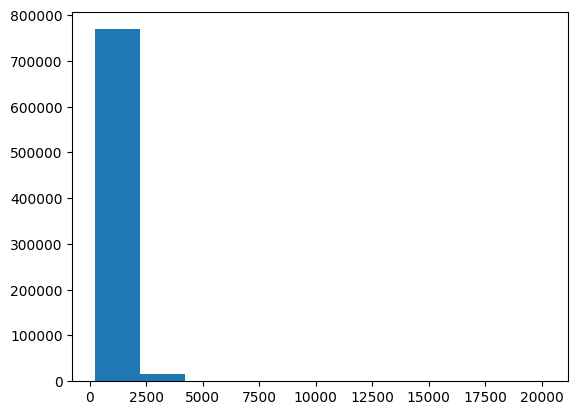

In [27]:
plt.hist(batch["image"].numpy().flatten())

Datasets return a dict

In [28]:
datamodule.train_dataset[0].keys()

dict_keys(['image', 'label'])

In [29]:
datamodule.train_dataset.bands

('B04', 'B03', 'B02')

Experiment with the model and pretrained weights -> https://torchgeo.readthedocs.io/en/stable/tutorials/pretrained_weights.html

In [30]:
task = ClassificationTask(
    model="resnet18",
    # weights=True, # standard Imagenet
    # weights=ResNet18_Weights.SENTINEL2_ALL_MOCO, # or try sentinel 2 all bands
    weights=ResNet18_Weights.SENTINEL2_RGB_MOCO, # or try sentinel 2 rgb bands
    num_classes=10,
    in_channels=len(datamodule.train_dataset.bands), # make sure to validate
    loss="ce", 
    patience=10
)

In [31]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

logger = TensorBoardLogger("tensorboard_logs", name="eurosat")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    # accelerator=device,
    logger=logger,
    # default_root_dir=experiment_dir,
    min_epochs=15,
    max_epochs=50,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=15` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [33]:
trainer.test(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.9335962533950806     │
│       test_F1Score        │    0.9353703856468201     │
│     test_JaccardIndex     │    0.8776867985725403     │
│   test_OverallAccuracy    │    0.9353703856468201     │
│         test_loss         │    0.2393910437822342     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2393910437822342,
  'test_AverageAccuracy': 0.9335962533950806,
  'test_F1Score': 0.9353703856468201,
  'test_JaccardIndex': 0.8776867985725403,
  'test_OverallAccuracy': 0.9353703856468201}]

The model checkpoint is saved below:

In [34]:
os.listdir("tensorboard_logs/eurosat/version_0/checkpoints")

['epoch=7-step=2032.ckpt']